# Density matrix exponentiation
## Overview
This is a function to simulate DME. It follows the protocol laid down by https://arxiv.org/abs/2001.08838

Goals: implement the unitary $U=e^{-i\rho\theta}$ on data qubit $\sigma$ (rotate $\sigma$ by $\theta$) according to instruction given by instruction qubit $\rho$.

DME uses the relation (rotate $\sigma$ by small angle $\delta = \sigma/N$).
$$\begin{align}
Tr_\rho [e^{-iSWAP\delta}\sigma\otimes\rho e^{iSWAP\delta}] &= \sigma - i\delta[\rho,\sigma] +\mathcal{O}(\delta^2)\\
&= e^{-i\rho\delta}\sigma e^{i\rho\delta}+\mathcal{O}(\delta^2)
\end{align}$$

Reference
- Kjaergaard, M., Schwartz, M. E., Greene, A., Samach, G. O., Bengtsson, A., O'Keeffe, M., ... Oliver, W. D. (2020). 
    Programming a quantum computer with quantum instructions. arXiv preprint arXiv:2001.08838. 
    Retrieved from https://arxiv.org/abs/2001.08838 


## Code exlanation
In this code, we set $\theta = \pi, N =k$ with 1 work qubit and $k$ instruction qubits (it is possible to set more instruction qubits here, but they will just be idle). 

The instruction qubits are thrown out after usage (We call it Sequential Instruction Qubit protocol). Each query use, accordingly, k qubits. Each call use 1 query.

Our goal is to rotate qubit 0 from state $\ket{0}$ to state $\ket{1}$ by using an $RX(\pi)$ pulse. We demonstrate this by showing the number of counter that return 1.

In [1]:
from qibo.models.qdp.quantum_dynamic_programming import DensityMatrixExponentiation
import numpy as np
from qibo import gates
theta = np.pi/2

### Expectation

In [2]:
k = 1
my_protocol = DensityMatrixExponentiation(theta=theta/2,N=k,num_work_qubits=1,num_instruction_qubits=k,number_muq_per_call=1)
my_protocol.memory_call_circuit(num_instruction_qubits_per_query=k)
print('Circuit for DME, q0 is target qubit, q1,q2 and q3 are instruction qubit')
print(my_protocol.c.draw())
qubit_0 = my_protocol.c.execute(nshots=1000).probabilities([0])
qubit_0 = np.round(np.sqrt(qubit_0),3)
print(f'Final state = {qubit_0[0]}*|0> + {qubit_0[1]}*|1>')

[Qibo 0.2.7|INFO|2024-05-29 11:33:22]: Using qibojit (numba) backend on /CPU:0


Circuit for DME, q0 is target qubit, q1,q2 and q3 are instruction qubit
q0: ─U───o─U─o─U─o─U───
q1: ─X─U─Z─U─Z─U─Z─U─M─
Final state = 0.707*|0> + 0.707*|1>


### Test with 3 iterations

In [3]:
k = 3
my_protocol = DensityMatrixExponentiation(theta=theta/2,N=k,num_work_qubits=1,num_instruction_qubits=k,number_muq_per_call=1)
my_protocol.memory_call_circuit(num_instruction_qubits_per_query=k)
print('Circuit for DME, q0 is target qubit, q1,q2 and q3 are instruction qubit')
print(my_protocol.c.draw())
qubit_0 = my_protocol.c.execute(nshots=1000).probabilities([0])
qubit_0 = np.round(np.sqrt(qubit_0),3)
print(f'Final state = {qubit_0[0]}*|0> + {qubit_0[1]}*|1>')

Circuit for DME, q0 is target qubit, q1,q2 and q3 are instruction qubit
q0: ─U───o─U─o─U─o─U─U─o─U─o─U─o─U─U─o─U─o─U─o─U───
q1: ─X─U─Z─U─Z─U─Z─U─M─|───|───|─────|───|───|─────
q2: ─X─────────────U───Z─U─Z─U─Z─U─M─|───|───|─────
q3: ─X───────────────────────────U───Z─U─Z─U─Z─U─M─
Final state = 0.901*|0> + 0.433*|1>


### Test with 20 iterations

In [4]:
k = 20
my_protocol = DensityMatrixExponentiation(theta=theta/2,N=k,num_work_qubits=1,num_instruction_qubits=k,number_muq_per_call=1)
my_protocol.memory_call_circuit(num_instruction_qubits_per_query=k)
#print('Circuit for DME, q0 is target qubit, q1,q2 and q3 are instruction qubit')
#print(my_protocol.c.draw())
qubit_0 = my_protocol.c.execute(nshots=1000).probabilities([0])
qubit_0 = np.round(np.sqrt(qubit_0),3)
print(f'Final state = {qubit_0[0]}*|0> + {qubit_0[1]}*|1>')

Final state = 0.985*|0> + 0.174*|1>


## Fidelity with analytic

In [5]:
from qutip import ptrace, basis, tensor, Qobj, fidelity
from qutip.qip.operations import swap
import matplotlib.pyplot as plt

In [6]:
def compare_dme_analytic(num_iteration,theta):
    my_protocol = DensityMatrixExponentiation(theta=theta,N=num_iteration,num_work_qubits=1,num_instruction_qubits=num_iteration,number_muq_per_call=1)
    my_protocol.memory_call_circuit(num_instruction_qubits_per_query=num_iteration) 
    c = my_protocol.c
    result = c(nshots=1000)
    qibo_state = Qobj(result.state().reshape((2**(num_iteration+1),1)), dims=[[2]*(num_iteration+1),[1]*(num_iteration+1)]).ptrace(0)

    
    delta_SWAP = (swap(2,[0,1])*theta/num_iteration).expm()
    sigma = basis(2,0) * Qobj(np.array([[1, 0]]))
    rho = basis(2,1) * Qobj(np.array([[0, 1]]))
    for i in range(num_iteration):
        current_state = tensor(sigma,rho)
        current_state = (delta_SWAP * tensor(sigma,rho))
        sigma = current_state.ptrace(0)
    qutip_state = sigma/(sigma.norm())

    #delta_SWAP = (swap(2,[0,1])).expm()
    #sigma = basis(2,0) * Qobj(np.array([[1, 0]]))
    #rho = basis(2,1) * Qobj(np.array([[0, 1]]))
    #current_state = tensor(sigma,rho)
    #current_state = (delta_SWAP * tensor(sigma,rho))
    #sigma = current_state.ptrace(0)
    #targeted_final_state = sigma/(sigma.norm())
    
    return(fidelity(qutip_state,qibo_state))#, fidelity(targeted_final_state,qutip_state)

Text(0.5, 1.0, 'Final state after Density Matrix Exponentiation with qibo.models.qdp')

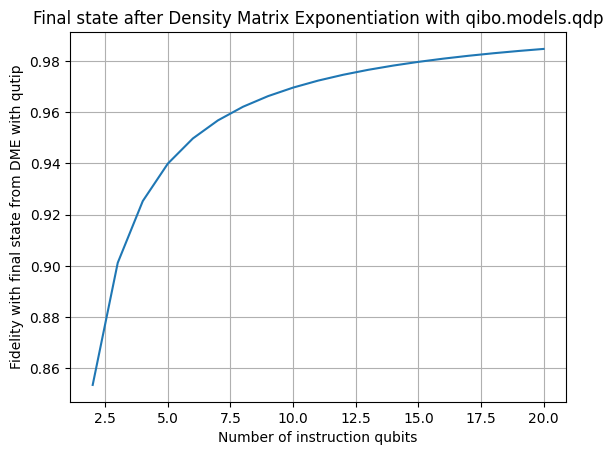

In [7]:
fidelities = []
for i in range(2,21):
    fidelities.append(compare_dme_analytic(i,theta=np.pi/4))

plt.plot(range(2,21),fidelities)
plt.grid()
plt.xlabel('Number of instruction qubits')
plt.ylabel('Fidelity with final state from DME with qutip')
plt.title('Final state after Density Matrix Exponentiation with qibo.models.qdp')

In [8]:
iterations = 20
count_1 = np.zeros(iterations)
for k in range(1,iterations+1):
    my_protocol = DensityMatrixExponentiation(theta=np.pi,N=k,num_work_qubits=1,num_instruction_qubits=k,number_muq_per_call=1)
    my_protocol.memory_call_circuit(num_instruction_qubits_per_query=k)
    #print('Circuit for DME, q0 is target qubit, q1,q2 and q3 are instruction qubit')
    #print(my_protocol.c.draw())
    my_protocol.c.add(gates.M(0))
    my_dict = my_protocol.c.execute(nshots=1000).frequencies(registers = True)
    my_counter = my_dict['register0']
    # print(f'Count of qubit 0: {my_counter}')
    count_1[k-1] = my_counter['1']
count_1 /= 1000

Text(0, 0.5, 'Count of $|1\\rangle$')

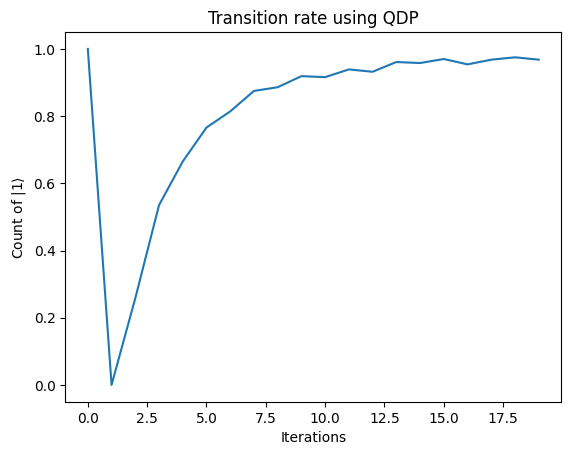

In [9]:
import matplotlib.pyplot as plt
plt.plot(count_1)
plt.title('Transition rate using QDP')
plt.xlabel('Iterations')
plt.ylabel(r'Count of $|1\rangle$')